In [28]:
import torch
import torch.backends.cudnn as cudnn

import umap
import random
import numpy as np
import matplotlib.pyplot as plt
from networks.resnet_big import SupConResNet
from sklearn.neighbors import NearestNeighbors

In [19]:
def extract_features(loader, model):
    model.eval()  # Set the model to evaluation mode
    features = []
    labels = []

    with torch.no_grad():
        for idx, (images, labels_batch) in enumerate(loader):

            labels_batch = (labels_batch, labels_batch)
            images = torch.cat(images, dim=0)  # Adjust if your loader structure is different
            labels_batch = torch.cat(labels_batch, dim=0)  # Adjust if your loader structure is different
            
            images = images.cuda(non_blocking=True)
            labels_batch = labels_batch.cuda(non_blocking=True)

            # Extract features
            output = model.encoder(images)
            features.extend(output.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())

    features = np.array(features)
    labels = np.array(labels)
    return features, labels

In [21]:
def set_model(ckpt):
    model = SupConResNet(name='resnet50')
    criterion = torch.nn.CrossEntropyLoss()

    ckpt = torch.load(ckpt, map_location='cpu')
    state_dict = ckpt['model']

    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model.encoder = torch.nn.DataParallel(model.encoder)
        else:
            new_state_dict = {}
            for k, v in state_dict.items():
                k = k.replace("module.", "")
                new_state_dict[k] = v
            state_dict = new_state_dict
        model = model.cuda()
        cudnn.benchmark = True

        model.load_state_dict(state_dict)
    else:
        raise NotImplementedError('This code requires GPU')

    return model

In [22]:
from main_ce import elastic_transform, apply_elastic_deformation
from torchvision import transforms, datasets
from OCT.oct import OCTDataset

In [23]:
def set_loader():
    oct_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=10),  # Slightly larger rotation
        transforms.RandomResizedCrop(size=(64, 64), scale=(0.75, 1.0)),  # Adjust the cropping scale
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2)], p=0.3),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.Lambda(lambda img: apply_elastic_deformation(img) if random.random() < 0.5 else img),
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.32978319597], std=[0.10885790758])
    ])
    
    directory = "/app/Data/OCTA_3mm"
    train_sampler = None

    val_dataset = OCTDataset(directory=directory,
                               transform=oct_transforms, patient_numbers=[i for i in [10302, 10310, 10311, 10312]],mm=3, label=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=32, shuffle=(train_sampler is None),
        num_workers=16, pin_memory=True, sampler=train_sampler)

    return val_loader

In [24]:
# Load trained model
model = set_model('/app/SimCLR-OCT/save/SupCon/oct_models/SupCon_oct_resnet50_lr_0.05_decay_0.0001_bsz_8_temp_0.07_trial_0_cosine/ckpt_epoch_50.pth')
model.eval()

if torch.cuda.is_available():
    model.cuda()

# Extract features and labels
val_loader = set_loader()  # Make sure this loader is for the validation set
features, labels = extract_features(val_loader, model)

In [63]:
def visualize_with_umap(features, labels):
    reducer = umap.UMAP(n_neighbors=100, min_dist=0.1, metric='correlation')
    embedding = reducer.fit_transform(features)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(len(np.unique(labels))+1)-0.5).set_ticks(np.unique(labels))
    plt.title('UMAP projection of the OCTA500 Dataset', fontsize=24)
    plt.show()

In [64]:
for i, _ in enumerate(labels):
    if labels[i] != 0:
        labels[i] = 1

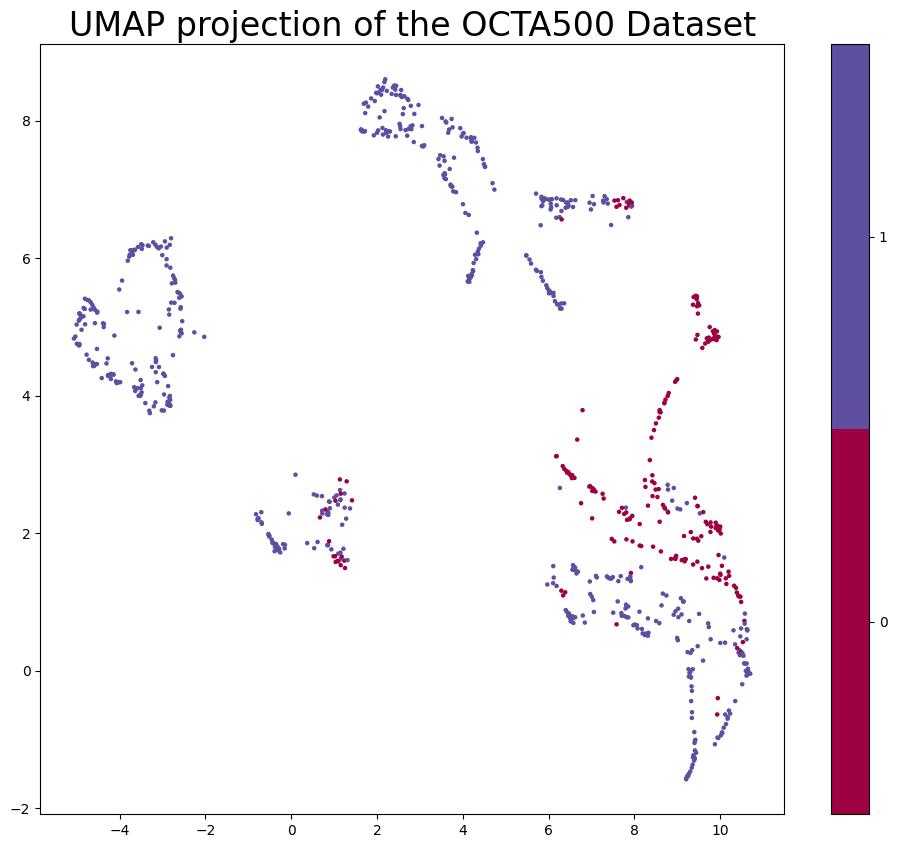

In [65]:
# Visualization
visualize_with_umap(features, labels)